Imports and General Setup

In [ ]:

# -----------------------------------------------
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# -----------------------------------------------
# Standard Python imports
import logging
import os
import numpy as np
import pandas as pd
from collections import OrderedDict
import seaborn as sns
from matplotlib import pyplot as plt
import itertools
from tqdm import tqdm
import json

# -----------------------------------------------
# MNE: Core library for EEG data handling, preprocessing, and visualization
import mne
from mne import Epochs, find_events
from mne.decoding import Vectorizer
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.preprocessing import ICA  # For optional ICA artifact removal

# -----------------------------------------------
# AutoReject: Automatic rejection of bad EEG epochs
from autoreject import AutoReject

# -----------------------------------------------
# PyXDF: Library to handle the XDF format used for EEG recordings
import pyxdf
from mne_import_xdf import *

# -----------------------------------------------
# Scikit-learn and Pyriemann: Machine learning libraries for EEG classification
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Pyriemann: Provides tools for covariance matrix estimation and tangent space mapping
from pyriemann.estimation import ERPCovariances, XdawnCovariances, Xdawn, Covariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

# -----------------------------------------------
# MOABB (Mother of All BCI Benchmarks) - used here mainly for its filterbank utilities
from moabb.pipelines.utils import FilterBank

# -----------------------------------------------
# EasyGUI: Used for simple file selection dialogs (optional, depends on how files are chosen)
from easygui import *

# -----------------------------------------------
# Pathlib: More flexible path handling
import pathlib
from os import listdir
from os.path import isfile, join

# -----------------------------------------------
# PyQt5 for enabling interactive plotting in Jupyter (MNE visualization compatibility)
import PyQt5
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'qt')

# -----------------------------------------------
# Precision-recall curve utilities from scikit-learn
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay

# Other standard tools
from itertools import cycle
import matplotlib.pyplot as plt
import pickle
import copy

# -----------------------------------------------
# Braindecode: Deep learning tools for EEG, particularly ShallowFBCSPNet
from braindecode.models import ShallowFBCSPNet
from braindecode.datautil import create_from_mne_epochs
from braindecode.training import CroppedLoss
from braindecode.training.scoring import trial_preds_from_window_preds
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch

# -----------------------------------------------
# Import project-specific scripts
from preprocessing import *
from training import *
from evaluation import *

# --------------------------------------------------------------------------------------
# Path Setup
# --------------------------------------------------------------------------------------

# Path to the main project folder
current_path = pathlib.Path().absolute()

# Path where EEG recordings are stored (assumed under "Recordings/")
recording_path = current_path / 'Recordings'

# Path for storing output figures
figure_outputs_path = current_path / 'Figures'

# --------------------------------------------------------------------------------------
# File Discovery
# --------------------------------------------------------------------------------------

# List all files in the 'Recordings' folder with .xdf extension
recording_files = [
    f for f in listdir(recording_path)
    if isfile(join(recording_path, f)) and ('.xdf' in f)
]

# Ensure figure output directory exists, warn if not
if not figure_outputs_path.exists():
    print('The output folder does not exist: ', figure_outputs_path)

# Log found files
print('All available recording files:', recording_files)

# Extract subject names from file names (assumes files are named "<subject>_rest.xdf" etc.)
subject_names = [r.split('_')[0] for r in recording_files]
print('Only subject IDs:', subject_names)

# Initial filename and subject logging
print('Filenames:\n', recording_files)
print('Subject names:\n', subject_names)

# --------------------------------------------------------------------------------------
# Electrode Group Definitions
# --------------------------------------------------------------------------------------
# These are predefined groups of electrodes that can be used for analysis.
# They help to select specific scalp regions, e.g., frontal (F), central (C), etc.
Electorde_Groups = {
    'FP': ['Fp1', 'Fp2'],  # Frontal Pole
    'AF': ['AF7', 'AF3', 'AFz', 'AF4', 'AF8'],  # Anterior Frontal
    'F': ['F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8'],  # Frontal
    'FC': ['FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6'],  # Fronto-Central
    'C': ['C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6'],  # Central
    'CP': ['CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6'],  # Centro-Parietal
    'P': ['P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8'],  # Parietal
    'PO': ['PO7', 'PO3', 'POz', 'PO4', 'PO8'],  # Parieto-Occipital
    'O': ['Oz', 'O2', 'O1', 'Iz']  # Occipital
}


all available recording files ['Fudge_MI3_1.xdf', 'Fudge_MI3_2.xdf', 'Fudge_MI3_3.xdf', 'Fudge_MI3_4.xdf', 'Gilad2_MI3_3.xdf', 'Gilad2_MI3_4.xdf', 'Gilad_3_AO.xdf', 'Gilad_MI3_1.xdf', 'Gilad_MI3_2.xdf', 'Gi_Block_1.xdf', 'Gi_Block_3.xdf', 'Gi_Block_4.xdf', 'g_mi_1.xdf', 'g_mi_3.xdf', 'g_mi_4.xdf', 'NH37_Block_1.xdf', 'NH37_Block_2.xdf', 'NH37_Block_3.xdf', 'NH_34_MI5.xdf', 'NH_34_MI6.xdf', 'NH_3_AO.xdf', 'NH_3_MI1.xdf', 'NH_3_MI2.xdf', 'NH_3_MI3.xdf', 'NH_3_MI4.xdf', 'NH_Block_3.xdf', 'Or_MI_1.xdf', 'Or_MI_2.xdf', 'Or_MI_3.xdf', 'Rating.xdf', 'Realtime_annotations.xdf', 'Rg_mi_2.xdf', 'Roei-MI_1.xdf', 'Roei-MI_2.xdf', 'Roei-MI_3.xdf', 'Ron_3rd_MI_01.xdf', 'Ron_3rd_MI_02.xdf', 'Ron_3rd_MI_03.xdf', 'Ron_MI_3_1.xdf', 'Ron_MI_3_2.xdf', 'Ron_MI_3_3.xdf', 'Ron_MI_3_4.xdf']
only subjects IDS: ['Fudge', 'Fudge', 'Fudge', 'Fudge', 'Gilad2', 'Gilad2', 'Gilad', 'Gilad', 'Gilad', 'Gi', 'Gi', 'Gi', 'g', 'g', 'g', 'NH37', 'NH37', 'NH37', 'NH', 'NH', 'NH', 'NH', 'NH', 'NH', 'NH', 'NH', 'Or', 'Or', 'O

Create a parameter dictionary 

In [2]:
params_dict={}
params_dict['PerformCsd']=True
Electorde_Group_Names='F+FC+C+CP+P+PO'
params_dict['Electorde_Group']=[] 
for cur_elec_group_name in Electorde_Group_Names.split('+'):
    params_dict['Electorde_Group']=params_dict['Electorde_Group']+Electorde_Groups[cur_elec_group_name]
params_dict['bad_electrodes'] = get_subject_bad_electrodes ('Fudge') # Manually define subject name
params_dict['filter_method']='fir'
params_dict['epoch_tmins_and_maxes_grid'] = [-4,6]
params_dict['epoch_tmin'] = -4
params_dict['epoch_tmax'] = 6
params_dict['n_components']= 8
params_dict['LowPass']=5
params_dict['HighPass']=35
params_dict['filters_bands']=[[7, 12], [12, 20], [20, 28], [28, 35]]
params_dict['augmentation_params']={'win_len': 1, 'win_step': 0.1}
params_dict['classifier_window_s']=1
params_dict['classifier_window_e']=2
params_dict['windowed_prediction_params']={'win_len': 2, 'win_step': 0.1}
params_dict['pipeline_name']='csp+lda'
params_dict['n_components_fbcsp']=10
params_dict['desired_events'] = ['ActiveRest','OpenPalm'] 


Load XDF files and convert to combined mne Raw instance

In [28]:
xdf_files = [f for f in recording_path.glob('*.xdf') if 'Rating' in  f.name] # fill in name to select subject files
#OriginalRaw = Load_and_concatenate_xdf(xdf_files)
xdf_files

[WindowsPath('c:/Users/gilad/3_Class_MI_21_01_25/Recordings/Rating.xdf')]

In [29]:
epochs_list = []
filter_bank_epochs_list = []
for xdf_file in xdf_files[:]:
    raw=read_raw_xdf(xdf_file)
    epoch,filter_bank_epochs,mean_across_epochs, events_trigger_dict = EEG_Preprocessing(current_path,raw,params_dict)
    epochs_list.append(epoch)
    filter_bank_epochs_list.append(filter_bank_epochs)

print("Concatenating all preprocessed epochs...")
epochs = mne.concatenate_epochs(epochs_list, on_mismatch='warn')
filter_bank_epochs = None

Creating RawArray with float64 data, n_channels=67, n_times=70751
    Range : 0 ... 70750 =      0.000 ...   141.500 secs
Ready.

###########################################################
removing subject specific bad electrodes from the raw data

###########################################################
removing bad channels from epochs:
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.

###########################################################
filtering the data
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower tr

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.0s finished


OpenPalm
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated

###########################################################
removing bad channels from epochs:
Concatenating all preprocessed epochs...
Not setting metadata
8 matching events found
No baseline correction applied


In [32]:
raw.plot()

Channels marked as bad:
none


In [31]:
# Update annotations
annotations.description = new_descriptions
raw.set_annotations(annotations)

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,68 points
Good channels,58 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.00 Hz
Lowpass,250.00 Hz


In [ ]:
rating_prefix = "Rating-"
annotations = raw.annotations
movement_events = ['ClosePalm','OpenPalm'] 

# Step 1: Modify Annotations - Merge Ratings into Previous Event
new_descriptions = []
for i, desc in enumerate(annotations.description):
    if desc in movement_events:  # If it's a movement event
        trial_onset = annotations.onset[i]
        
        # Check the next annotation for a rating
        if i + 1 < len(annotations.description):
            next_desc = annotations.description[i + 1]
            if next_desc.startswith(rating_prefix):  # Extract rating
                new_desc = f"{desc}_{next_desc}"  # Merge e.g., 'Right_Rating-5'
            else:
                new_desc = desc  # No rating, keep original
        else:
            new_desc = desc  # No next annotation, keep original
        new_descriptions.append(new_desc)
    elif desc.startswith(rating_prefix):  
        new_desc = None  # Skip rating annotations after merging
    
    else:
        new_desc = desc  # Keep other annotations unchanged
        
    

In [93]:
xdf_files[2:3]

[WindowsPath('c:/Users/gilad/3_Class_MI_21_01_25/Recordings/Ron_3rd_MI_03.xdf')]

Pre-processing

In [9]:
events = epochs.events
event_dict = epochs.event_id
params_dict['events_trigger_dict'] = {key: event_dict[key] for key in event_dict.keys() if key in params_dict['desired_events']}
train_inds,validation_inds,return_dict = Split_training_validation (epochs,filter_bank_epochs, params_dict['events_trigger_dict'])
epochs_copy = epochs.copy()
returned_dict=crop_the_data(epochs_copy,train_inds,validation_inds,params_dict['classifier_window_s'],params_dict['classifier_window_e']) #two more paramters here are tmin and tmax which are not used apparently. 
train_set_data_uncropped=returned_dict['train_set_data_uncropped']
epochs_cropped=returned_dict['epochs_cropped']
train_set_data=returned_dict['train_set_data']
train_set_labels=returned_dict['train_set_labels']

validation_set_labels=returned_dict['validation_set_labels']
validation_set_data_uncropped=returned_dict['validation_set_data_uncropped']
#define cv on the data: 
cv = StratifiedShuffleSplit(5, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_cropped.get_data(),events[:,2])

#filter bank related:
if params_dict['pipeline_name']=='fbcsp+lda': 
    train_set_data_fb=[]
    train_set_data_uncropped_fb=[]
    validation_set_data_fb=[]
    validation_set_data_uncropped_fb=[]
    for filtered_data_band_epoch in preprocessing_dict['filter_bank_epochs']:
        returned_dict_temp=crop_the_data(filtered_data_band_epoch,train_inds,validation_inds, params_dict['classifier_window_s'],params_dict['classifier_window_e'])
        #extract the train set data: 
        train_set_data_uncropped_temp=returned_dict_temp['train_set_data_uncropped']
        train_set_data_temp=returned_dict_temp['train_set_data']
        train_set_data_fb.append(train_set_data_temp)
        train_set_data_uncropped_fb.append(train_set_data_uncropped_temp)
        #extract the validation set data: 
        validation_set_data_uncroped_temp=returned_dict_temp['validation_set_data_uncroped']
        validation_set_data_temp=returned_dict_temp['validation_set_data']
        validation_set_data_fb.append(validation_set_data_temp)
        validation_set_data_uncropped_fb.append(validation_set_data_uncroped_temp)
    #create a 4d matrix of train data:     
    train_set_data_4d_array= np.transpose(np.array(train_set_data_fb),(1,2,3,0))
    train_set_data_uncropped_4d_array=np.transpose(np.array(train_set_data_uncropped_fb),(1,2,3,0)) 
    train_set_data=train_set_data_4d_array
    train_set_data_uncropped=train_set_data_uncropped_4d_array
    #create a 4d matrix of validation data: 
    validation_set_data_4d_array= np.transpose(np.array(validation_set_data_fb),(1,2,3,0))
    validation_set_data_uncropped_4d_array=np.transpose(np.array(validation_set_data_uncropped_fb),(1,2,3,0)) 
    validation_set_data_uncropped=validation_set_data_uncropped_4d_array


augmented_x,augmented_y = augment_data(params_dict['augmentation_params'], train_set_data,train_set_labels,epochs.info['sfreq'])

triggers_label_dict={val:key for key,val in params_dict['events_trigger_dict'].items()} 
test_data_y_labels=np.array([triggers_label_dict[cur_y] for cur_y in validation_set_labels])  
augmented_y_labels=np.array([triggers_label_dict[cur_y] for cur_y in augmented_y])  


putting aside 20% of the data: trial numbers are:
 [ 29  81 131 134 106  48  77 102  79 121  28   3  42 105  18  15   2  91
  45 142  44  49 127 118  82  55  46  60   1]

remaining 80% of the trials go into training for cv:
 [ 20  96   8  87  84  75 143 136 119  37  16 111  89  62  68  12  88  10
  39  38 108   6  58 116 114 101 107  74 113  17  69  22  14  83 115  13
  11 103  26  85  23  61 137  52 139 117  47  30  73  34 132  53  80  59
  27   5 112  72  99 138   0 129  36  95  67 133  51 109  70 144 123   9
 122  86  24  40 126  35  64  71 135 140 100  43  31  56  93  97  54 128
  66  25  21  33 141  41  19 124 110   7  94  78  92  50 125 120  98  57
  76  63  32  90 104  65   4 130]



Cross-Validation Evaluation 

In [10]:
scores_windows,folds_confusion_matrices_per_window,w_times= run_windowed_classification_aug_cv(epochs, returned_dict['epochs_cropped'], cv_split,params_dict)

Computing rank from data with rank=None
    Using tolerance 0.023 (2.2e-16 eps * 42 dim * 2.5e+12  max singular value)
    Estimated rank (mag): 42
    MAG: rank 42 computed from 42 data channels with 0 projectors
Reducing data rank from 42 -> 42
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.024 (2.2e-16 eps * 42 dim * 2.5e+12  max singular value)
    Estimated rank (mag): 42
    MAG: rank 42 computed from 42 data channels with 0 projectors
Reducing data rank from 42 -> 42
Estimating covariance using OAS
Done.
Class order in confusion matrix: ['ActiveRest' 'OpenPalm']
Computing rank from data with rank=None
    Using tolerance 0.022 (2.2e-16 eps * 42 dim * 2.4e+12  max singular value)
    Estimated rank (mag): 42
    MAG: rank 42 computed from 42 data channels with 0 projectors
Reducing data rank from 42 -> 42
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.025 (2.2e-16 eps * 42 di

In [11]:
plot_accuracy_over_time(scores_windows, w_times, params_dict, axes_handle=None)

In [17]:
w_step = int(500 * 0.1)   # running classifier: window length
w_length = int(500 * 2)
w_start = np.arange(0, epochs.get_data().shape[2] - w_length, w_step)

In [18]:
w_times = (w_start + w_length / 2.) / 500 + params_dict['epoch_tmin']


In [19]:
w_start

array([   0,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
        550,  600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050,
       1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600,
       1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150,
       2200, 2250, 2300, 2350, 2400, 2450, 2500, 2550, 2600, 2650, 2700,
       2750, 2800, 2850, 2900, 2950, 3000, 3050, 3100, 3150, 3200, 3250,
       3300, 3350, 3400, 3450, 3500, 3550, 3600, 3650, 3700, 3750, 3800,
       3850, 3900, 3950, 4000])

Training

In [20]:
clf,csp,lda = classifier_training(augmented_x,augmented_y,params_dict, BinaryClassification = False)

Computing rank from data with rank=None
    Using tolerance 0.023 (2.2e-16 eps * 42 dim * 2.5e+12  max singular value)
    Estimated rank (mag): 42
    MAG: rank 42 computed from 42 data channels with 0 projectors
Reducing data rank from 42 -> 42
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.024 (2.2e-16 eps * 42 dim * 2.5e+12  max singular value)
    Estimated rank (mag): 42
    MAG: rank 42 computed from 42 data channels with 0 projectors
Reducing data rank from 42 -> 42
Estimating covariance using OAS
Done.


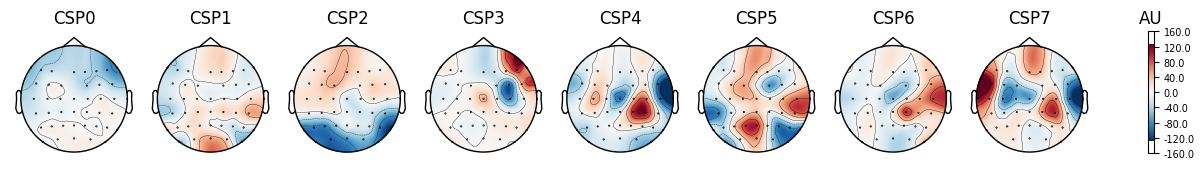

In [21]:
csp.plot_patterns(epochs.info)

In [22]:
w_length = int(raw.info['sfreq'] * params_dict['windowed_prediction_params']['win_len'])   # running classifier: window length
w_step = int(raw.info['sfreq'] * params_dict['windowed_prediction_params']['win_step'])  # running classifier: window step size
w_start = np.arange(0, train_set_data_uncropped.shape[2] - w_length, w_step)
w_times = (w_start + w_length / 2.) / raw.info['sfreq'] + params_dict['epoch_tmin']

In [ ]:
confusion_matrices_per_window

[(array([[12,  2],
         [14,  1]], dtype=int64),
  array(['ActiveRest', 'OpenPalm'], dtype='<U10')),
 (array([[12,  2],
         [14,  1]], dtype=int64),
  array(['ActiveRest', 'OpenPalm'], dtype='<U10')),
 (array([[12,  2],
         [14,  1]], dtype=int64),
  array(['ActiveRest', 'OpenPalm'], dtype='<U10')),
 (array([[11,  3],
         [14,  1]], dtype=int64),
  array(['ActiveRest', 'OpenPalm'], dtype='<U10')),
 (array([[11,  3],
         [14,  1]], dtype=int64),
  array(['ActiveRest', 'OpenPalm'], dtype='<U10')),
 (array([[12,  2],
         [12,  3]], dtype=int64),
  array(['ActiveRest', 'OpenPalm'], dtype='<U10')),
 (array([[12,  2],
         [13,  2]], dtype=int64),
  array(['ActiveRest', 'OpenPalm'], dtype='<U10')),
 (array([[12,  2],
         [13,  2]], dtype=int64),
  array(['ActiveRest', 'OpenPalm'], dtype='<U10')),
 (array([[12,  2],
         [13,  2]], dtype=int64),
  array(['ActiveRest', 'OpenPalm'], dtype='<U10')),
 (array([[12,  2],
         [13,  2]], dtype=int64),
  

Channels marked as bad:
none


In [23]:
scores_per_time_window,confusion_matrices_per_window = run_windowed_pretrained_classifier(clf,validation_set_data_uncropped,test_data_y_labels,w_start,w_length)


Class order in confusion matrix: ['ActiveRest' 'OpenPalm']


In [24]:
plot_accuracy_over_time(scores_per_time_window, w_times, params_dict, axes_handle=None)

IndexError: tuple index out of range

In [38]:
train_set_data_uncropped.shape[2] + 500- w_length

3501

In [22]:
scores_windows_array = np.squeeze(np.array(scores_per_time_window))

In [23]:
scores_windows_array.shape

(71,)

In [15]:
confusion_matrices_per_window

NameError: name 'confusion_matrices_per_window' is not defined

In [14]:
import numpy as np

def merge_conf_matrix_tuple(conf_matrix_tuple):
    """
    Converts a 4-class confusion matrix into a 2-class confusion matrix
    by merging:
    - 'ActiveRest' (0) & 'Rest' (3) → Class 0
    - 'ClosePalm' (1) & 'OpenPalm' (2) → Class 1

    Args:
    conf_matrix_tuple (tuple): (4x4 confusion matrix, class labels)

    Returns:
    tuple: (2x2 merged confusion matrix, new class labels)
    """
    cm_4class, class_labels = conf_matrix_tuple  # Extract confusion matrix & labels

    # Merge rows (true labels)
    row_0 = cm_4class[0] + cm_4class[3]  # Merge 'ActiveRest' (0) & 'Rest' (3)
    row_1 = cm_4class[1] + cm_4class[2]  # Merge 'ClosePalm' (1) & 'OpenPalm' (2)

    # Merge columns (predicted labels)
    col_0 = row_0[0] + row_0[3]  # Merge predictions for 'ActiveRest' (0) & 'Rest' (3)
    col_1 = row_0[1] + row_0[2]  # Merge predictions for 'ClosePalm' (1) & 'OpenPalm' (2)
    col_2 = row_1[0] + row_1[3]  # Merge predictions for 'ActiveRest' (0) & 'Rest' (3)
    col_3 = row_1[1] + row_1[2]  # Merge predictions for 'ClosePalm' (1) & 'OpenPalm' (2)

    # Construct new 2x2 confusion matrix
    cm_binary = np.array([
        [col_0, col_1],  # Row 0 (New Class 0)
        [col_2, col_3]   # Row 1 (New Class 1)
    ])

    return (cm_binary, np.array(['rest', 'motor_imagery']))

# Example: Apply to all confusion matrices in the list
conf_matrices_merged = [merge_conf_matrix_tuple(cm_tuple) for cm_tuple in folds_confusion_matrices_per_window]

# Print merged confusion matrices
for i, (cm_bin, labels) in enumerate(conf_matrices_merged):
    print(f"\nBinary Confusion Matrix (Window {i+1}):")
    print(cm_bin)
    print("New Labels:", labels)


ValueError: too many values to unpack (expected 2)

In [20]:
import numpy as np

def average_conf_matrix(conf_matrices_merged, start_idx, end_idx):
    """
    Computes the average confusion matrix over a given index range.

    Args:
    conf_matrices_merged (list of tuples): [(2x2 confusion matrix, labels), ...]
    start_idx (int): Start index for averaging.
    end_idx (int): End index for averaging (inclusive).

    Returns:
    tuple: (Averaged 2x2 confusion matrix, class labels)
    """
    # Extract only the confusion matrices from the selected range
    selected_matrices = [cm[0] for cm in conf_matrices_merged[start_idx:end_idx+1]]

    # Convert to numpy array and compute the mean
    avg_conf_matrix = np.mean(np.array(selected_matrices), axis=0)

    # Round values to nearest integer (optional)
    avg_conf_matrix = np.round(avg_conf_matrix).astype(int)

    # Extract class labels (assume they're the same for all matrices)
    class_labels = conf_matrices_merged[0][1]

    return avg_conf_matrix, class_labels

# Example: Compute the average confusion matrix from index 2 to 5
start_idx, end_idx = 30, 71
avg_conf_matrix, avg_labels = average_conf_matrix(conf_matrices_merged, start_idx, end_idx)

# Print result
print("\nAverage Confusion Matrix (From Index", start_idx, "to", end_idx, "):")
print(avg_conf_matrix)
print("Labels:", avg_labels)


NameError: name 'conf_matrices_merged' is not defined

In [12]:
def merge_conf_matrix_tuple(conf_matrix_tuple):
    """
    Converts a 4-class confusion matrix into a 2-class confusion matrix
    by merging:
    - 'ActiveRest' (0) & 'Rest' (3) → Class 0
    - 'ClosePalm' (1) & 'OpenPalm' (2) → Class 1

    Args:
    conf_matrix_tuple (tuple): (4x4 confusion matrix, class labels)

    Returns:
    tuple: (2x2 merged confusion matrix, new class labels)
    """
    cm_4class, class_labels = conf_matrix_tuple  # Extract confusion matrix & labels

    # Merge rows (true labels)
    row_0 = cm_4class[0] + cm_4class[3]  # Merge 'ActiveRest' (0) & 'Rest' (3)
    row_1 = cm_4class[1] + cm_4class[2]  # Merge 'ClosePalm' (1) & 'OpenPalm' (2)

    # Merge columns (predicted labels)
    col_0 = row_0[0] + row_0[3]  # Merge predictions for 'ActiveRest' (0) & 'Rest' (3)
    col_1 = row_0[1] + row_0[2]  # Merge predictions for 'ClosePalm' (1) & 'OpenPalm' (2)
    col_2 = row_1[0] + row_1[3]  # Merge predictions for 'ActiveRest' (0) & 'Rest' (3)
    col_3 = row_1[1] + row_1[2]  # Merge predictions for 'ClosePalm' (1) & 'OpenPalm' (2)

    # Construct new 2x2 confusion matrix
    cm_binary = np.array([
        [col_0, col_1],  # Row 0 (New Class 0)
        [col_2, col_3]   # Row 1 (New Class 1)
    ])

    return (cm_binary, np.array(['rest', 'motor_imagery']))

# Example: Apply to all confusion matrices in all folds
conf_matrices_merged_all_folds = [
    [merge_conf_matrix_tuple(cm_tuple) for cm_tuple in fold] for fold in folds_confusion_matrices_per_window
]

def average_conf_matrix_folds(conf_matrices_all_folds, start_idx, end_idx):
    """
    Computes the average confusion matrix over multiple folds 
    for a given index range.

    Args:
    conf_matrices_all_folds (list of list of tuples): 
        A nested list where each fold contains a list of (confusion_matrix, labels).
    start_idx (int): Start index for averaging.
    end_idx (int): End index for averaging (inclusive).

    Returns:
    tuple: (Averaged 2x2 confusion matrix, class labels)
    """
    all_selected_matrices = []  # Store matrices from all folds
    valid_folds = 0  # Count number of folds that have valid data in range

    # Iterate through each fold
    for fold in conf_matrices_all_folds:
        # Ensure the fold has enough matrices for the given index range
        if len(fold) > end_idx:
            selected_matrices = [cm_tuple[0] for cm_tuple in fold[start_idx:end_idx+1]]
            all_selected_matrices.append(np.mean(selected_matrices, axis=0))  # Average over the time window in fold
            valid_folds += 1

    # Compute final average across valid folds
    if valid_folds > 0:
        avg_conf_matrix = np.mean(np.array(all_selected_matrices), axis=0)
    else:
        print("No valid folds for the given index range!")
        return None, None

    # Round values to nearest integer (optional)
    avg_conf_matrix = np.round(avg_conf_matrix).astype(int)

    # Extract class labels (assume same for all folds)
    class_labels = conf_matrices_all_folds[0][0][1]

    return avg_conf_matrix, class_labels

# Example: Compute the average confusion matrix from index 2 to 5 across folds
start_idx, end_idx = 50,60
avg_conf_matrix, avg_labels = average_conf_matrix_folds(conf_matrices_merged_all_folds, start_idx, end_idx)
print("\nAverage Confusion Matrix (Across Folds, From Index", start_idx, "to", end_idx, "):")
print(avg_conf_matrix)
print("Labels:", avg_labels)


IndexError: index 3 is out of bounds for axis 0 with size 2

In [16]:
# Example: Compute the average confusion matrix from index 2 to 5 across folds
start_idx, end_idx = 50,70
avg_conf_matrix, avg_labels = average_conf_matrix_folds(folds_confusion_matrices_per_window, start_idx, end_idx)

# Print result
print("\nAverage Confusion Matrix (Across Folds, From Index", start_idx, "to", end_idx, "):")
print(avg_conf_matrix)

print("Labels:", avg_labels)

NameError: name 'average_conf_matrix_folds' is not defined

In [95]:
trained_clf=clf
#data_to_predict=(data_set_fb_4d_array[inds,:])
data_to_predict=epochs.copy().crop(tmin=1,tmax=3).get_data()
thresholded_prediction=trained_clf.decision_function(data_to_predict)
prediction=trained_clf.predict(data_to_predict)

#note that here you can decide on which thresholds to use to better optimize your "real" usecase
#thresholded_prediction
yhat=trained_clf.predict(data_to_predict)
lr_probs = trained_clf.predict_proba(data_to_predict)

In [96]:
prediction

array(['ClosePalm', 'ActiveRest', 'Rest', 'ActiveRest', 'ClosePalm',
       'Rest', 'ClosePalm', 'Rest', 'ClosePalm', 'Rest', 'ActiveRest',
       'Rest', 'ClosePalm', 'Rest', 'OpenPalm', 'Rest', 'OpenPalm',
       'Rest', 'ClosePalm', 'Rest', 'OpenPalm', 'Rest', 'OpenPalm',
       'Rest', 'Rest', 'Rest', 'OpenPalm', 'Rest', 'ClosePalm', 'Rest',
       'ClosePalm', 'Rest', 'ClosePalm', 'Rest', 'ActiveRest', 'Rest',
       'ActiveRest', 'ClosePalm', 'ClosePalm', 'OpenPalm', 'Rest', 'Rest',
       'OpenPalm', 'ActiveRest', 'OpenPalm', 'ClosePalm', 'ClosePalm',
       'Rest', 'ClosePalm', 'ActiveRest', 'ActiveRest', 'ClosePalm',
       'ClosePalm', 'ClosePalm', 'OpenPalm', 'Rest', 'OpenPalm', 'Rest',
       'ClosePalm', 'Rest', 'OpenPalm', 'Rest', 'ActiveRest', 'Rest',
       'ActiveRest', 'Rest', 'OpenPalm', 'Rest', 'OpenPalm', 'Rest',
       'ActiveRest', 'Rest', 'ActiveRest', 'Rest', 'ActiveRest',
       'OpenPalm', 'OpenPalm', 'Rest', 'ActiveRest', 'Rest', 'ClosePalm',
       'Rest', 

In [97]:
# %%

from collections import Counter

# Function to get the list of event names for each epoch
def get_epoch_events(epochs):
    events = epochs.events  # Get the array of events
    event_ids = epochs.event_id  # Get the mapping from event name to event code
    epoch_event_names = []

    for event in events:
        event_code = event[-1]  # Extract the event ID
        # Get the event name using the event code
        event_name = [key for key, val in event_ids.items() if val == event_code][0]
        epoch_event_names.append(event_name)

    return np.array(epoch_event_names)

# Function to compare actual event names with predicted event names and summarize mismatches
def compare_events(actual_events, predicted_events):
    comparison = actual_events == predicted_events  # Element-wise comparison
    accuracy = np.mean(comparison)  # Calculate accuracy
    mismatches = np.where(comparison == False)[0]  # Get indices where predictions don't match
    
    # Collect mismatched epochs and count occurrences of each mismatch case
    mismatch_details = []
    mismatch_counts = Counter()
    
    for idx in mismatches:
        actual = actual_events[idx]
        predicted = predicted_events[idx]
        mismatch_details.append(f"{idx + 1} - {actual} (actual), {predicted} (predicted)")
        mismatch_counts[f"{actual} -> {predicted}"] += 1  # Count each specific mismatch case

    return {
        'accuracy': accuracy,
        'mismatch_details': mismatch_details,
        'mismatch_counts': mismatch_counts
    }

# Example usage:
# Assume `epochs` is your mne.Epochs object, and `predictions` is the model output

actual_events = get_epoch_events(epochs)  # Actual events from the epochs
predicted_events = np.array(prediction)  # Replace with your model predictions

# Compare actual events to predicted events
result = compare_events(actual_events, predicted_events)

# Output the comparison result
print(f"Accuracy: {result['accuracy']:.2f}")
if result['mismatch_details']:
    print("Mismatched epochs:")
    for mismatch in result['mismatch_details']:
        print(mismatch)
    
    print("\nMismatch Summary:")
    for mismatch_case, count in result['mismatch_counts'].items():
        print(f"{mismatch_case}: {count} occurrence(s)")
else:
    print("No mismatches!")


Accuracy: 0.52
Mismatched epochs:
1 - OpenPalm (actual), ClosePalm (predicted)
2 - Rest (actual), ActiveRest (predicted)
3 - ActiveRest (actual), Rest (predicted)
4 - Rest (actual), ActiveRest (predicted)
5 - OpenPalm (actual), ClosePalm (predicted)
9 - ActiveRest (actual), ClosePalm (predicted)
15 - ClosePalm (actual), OpenPalm (predicted)
17 - ActiveRest (actual), OpenPalm (predicted)
21 - ActiveRest (actual), OpenPalm (predicted)
23 - ActiveRest (actual), OpenPalm (predicted)
25 - ClosePalm (actual), Rest (predicted)
27 - ActiveRest (actual), OpenPalm (predicted)
29 - OpenPalm (actual), ClosePalm (predicted)
31 - OpenPalm (actual), ClosePalm (predicted)
33 - OpenPalm (actual), ClosePalm (predicted)
35 - OpenPalm (actual), ActiveRest (predicted)
38 - Rest (actual), ClosePalm (predicted)
39 - ActiveRest (actual), ClosePalm (predicted)
40 - Rest (actual), OpenPalm (predicted)
41 - ActiveRest (actual), Rest (predicted)
43 - ClosePalm (actual), OpenPalm (predicted)
44 - Rest (actual), Ac

In [98]:
epochs

Number of events,96
Events,ActiveRest: 16ClosePalm: 16OpenPalm: 17Rest: 47
Time range,-4.000 – 6.000 s
Baseline,off


In [138]:

# Example: Plot confusion matrix for the first time window
conf_matrix, class_labels = confusion_matrices_per_window[41]
plot_confusion_matrix(conf_matrix, class_labels)

In [92]:
scores_per_time_window

[0.5238095238095238,
 0.47619047619047616,
 0.5238095238095238,
 0.5238095238095238,
 0.5714285714285714,
 0.5714285714285714,
 0.6190476190476191,
 0.47619047619047616,
 0.5238095238095238,
 0.5714285714285714,
 0.5238095238095238,
 0.47619047619047616,
 0.38095238095238093,
 0.42857142857142855,
 0.47619047619047616,
 0.5238095238095238,
 0.5714285714285714,
 0.5238095238095238,
 0.47619047619047616,
 0.47619047619047616,
 0.5238095238095238,
 0.6190476190476191,
 0.5238095238095238,
 0.6190476190476191,
 0.6666666666666666,
 0.6190476190476191,
 0.7142857142857143,
 0.6666666666666666,
 0.6666666666666666,
 0.8095238095238095,
 0.7619047619047619,
 0.7619047619047619,
 0.7619047619047619,
 0.7619047619047619,
 0.7142857142857143,
 0.7619047619047619,
 0.7619047619047619,
 0.8095238095238095,
 0.8571428571428571,
 0.8571428571428571,
 0.8571428571428571,
 0.9047619047619048,
 0.8571428571428571,
 0.7619047619047619,
 0.8571428571428571,
 0.7619047619047619,
 0.7142857142857143,
 0.66

In [52]:
scores_per_time_window


[0.3142857142857143,
 0.37142857142857144,
 0.34285714285714286,
 0.3142857142857143,
 0.34285714285714286,
 0.34285714285714286,
 0.4,
 0.4857142857142857,
 0.4857142857142857,
 0.4857142857142857,
 0.42857142857142855,
 0.4,
 0.42857142857142855,
 0.4,
 0.45714285714285713,
 0.42857142857142855,
 0.45714285714285713,
 0.42857142857142855,
 0.42857142857142855,
 0.4857142857142857,
 0.4857142857142857,
 0.4857142857142857,
 0.4857142857142857,
 0.4857142857142857,
 0.45714285714285713,
 0.4857142857142857,
 0.4857142857142857,
 0.45714285714285713,
 0.42857142857142855,
 0.45714285714285713,
 0.5142857142857142,
 0.6,
 0.5714285714285714,
 0.5142857142857142,
 0.5428571428571428,
 0.5142857142857142,
 0.5714285714285714,
 0.6,
 0.5714285714285714,
 0.5714285714285714,
 0.5428571428571428,
 0.5428571428571428,
 0.5428571428571428,
 0.5142857142857142,
 0.5428571428571428,
 0.5142857142857142,
 0.45714285714285713,
 0.45714285714285713,
 0.45714285714285713,
 0.42857142857142855,
 0.485

In [118]:
def average_from_index_to_index(lst, start, end):
    # Ensure the indices are within the bounds of the list
    if start < 0 or end >= len(lst) or start > end:
        raise ValueError("Invalid start or end index")
    
    # Slice the list from start to end (inclusive)
    sublist = lst[start:end+1]
    
    # Calculate the average
    average = sum(sublist) / len(sublist)
    
    return average

# Example usage
start_index = 40
end_index =70
print(average_from_index_to_index(scores_per_time_window, start_index, end_index))  # Output: 35.0

0.5587929240374611


In [119]:
# Time points (assuming each point is 100 ms apart)
time_points = np.arange(0, len(scores_per_time_window) * 0.1, 0.1)  # in seconds

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(time_points, scores_per_time_window, marker='o')
plt.title('Sliding Window Scores Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Score')
plt.grid(True)
plt.show()

In [246]:
all_epoch_data = epochs.get_data()

In [247]:

scaler = RobustScaler()
all_epoch_data_flat = all_epoch_data.reshape(all_epoch_data.shape[0], -1)
all_epoch_data_normalized = scaler.fit_transform(all_epoch_data_flat).reshape(all_epoch_data.shape)

# Update combined epochs with normalized data
epochs._data = all_epoch_data_normalized

In [22]:
from sklearn.preprocessing import StandardScaler, RobustScaler


In [29]:
loaded_epochs = mne.read_epochs('epochs_combined-epo2.fif', preload=True)

Reading c:\Users\gilad\3_Class_MI_21_01_25\epochs_combined-epo2.fif ...
    Found the data of interest:
        t =   -3000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
